In [1]:
#!apt-get install git
#!pip install optuna

In [2]:
#!pip install opencv-python

In [3]:
#!pip install -q -U keras-tuner

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import shutil
import imghdr
#import optuna
#import keras_tuner as kt
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [5]:
!pip freeze > requirements.txt

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
# Hyperparameters

IMAGE_SIZE = (256,256,3)
OPT = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001)
BATCH_SIZE = 32
NUM_EPOCHS = 40


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
training_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Training'
testing_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Testing'

In [10]:
!nvidia-smi

Fri Dec 29 22:10:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [12]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

We can see from the above output that Tensorflow is using the NVIDIA Tesla T4 GPU.

In [13]:
for image_class in os.listdir(training_path):
  print(image_class)


glioma_tumor
pituitary_tumor
no_tumor
meningioma_tumor


- We can see that there is 3 different types of tumours that we have aswell as a folder where there is no tumor.

- To help improve the accuracy of the model, we will split this project into two steps. Firstly, we will classify weather or not a tumor is present.

- If a Tumor is present we will thelafywhattkof tumor it is.

In [14]:
os.listdir(training_path)

['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']

In [15]:
os.listdir(os.path.join(training_path,'pituitary_tumor'))[0:5]

['p (221).jpg', 'p (161).jpg', 'p (401).jpg', 'p (420).jpg', 'p (203).jpg']

In [16]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [17]:
img = cv2.imread(os.path.join(training_path, 'pituitary_tumor', 'p (503).jpg'))

In [18]:
img.shape # We can see the image is a 512x512 with a depth of 3

(512, 512, 3)

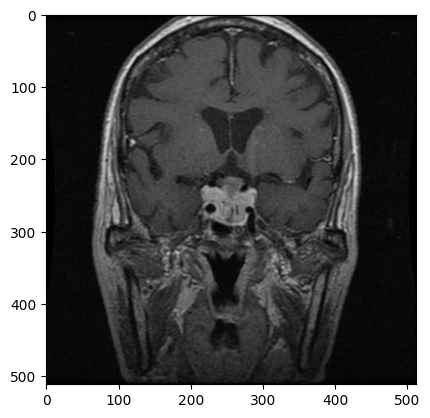

In [19]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB ))
plt.show()

In [20]:
for image_class in os.listdir(training_path):
  for image in os.listdir(os.path.join(training_path, image_class)):
    image_path = os.path.join(training_path, image_class, image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))
        # os.remove(image_path)

In [21]:
for image_class in os.listdir(testing_path):
  for image in os.listdir(os.path.join(testing_path, image_class)):
    image_path = os.path.join(testing_path, image_class, image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))
        # os.remove(image_path)

# Loading data

The datset was already split into testing and training data so we do not need to define these later

### Data Augmentation

In [22]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Set up data augmentation parameters
# data_augmentation = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

In [23]:
# data_augmentation.fit(Training_data)

In [24]:
# Load the training dataset
Training_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',  # Automatically infer labels from the directory structure
    image_size = (256,256),
    batch_size = BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=42
)

# Load the validation dataset
Validation_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    image_size = (256,256),
    batch_size = BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42
)

# Load the testing dataset
Testing_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    labels='inferred',
    image_size = (256,256),
    batch_size = BATCH_SIZE
)

Found 2910 files belonging to 4 classes.
Using 2328 files for training.
Found 2910 files belonging to 4 classes.
Using 582 files for validation.
Found 394 files belonging to 4 classes.


In [25]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Set up data augmentation parameters
# data_augmentation = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# Training_data = tf.keras.utils.image_dataset_from_directory(
#     training_path,
#     labels='inferred',
#     image_size=(256, 256),
#     batch_size=32,
#     validation_split=0.2,
#     subset='training',
#     seed=42,
#     num_parallel_calls=1,
#     image_augmentation=data_augmentation  # Pass the data augmentation generator
# )

In [26]:
Validation_data.class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [27]:
Testing_data.class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [28]:
Training_iterator = Training_data.as_numpy_iterator()
Testing_iterator = Testing_data.as_numpy_iterator()


In [29]:
Training_iterator

In [30]:
batch_training = Training_iterator.next()
batch_testing = Testing_iterator.next()

In [31]:
len(batch_training)

2

len of 2 as the image is 1 dimension and the label is the  other

In [32]:
batch_training[0].shape

(32, 256, 256, 3)

In [33]:
batch_training[1][1]

0

In [34]:
batch_training[1]

array([1, 0, 3, 0, 0, 3, 1, 3, 3, 1, 0, 3, 2, 0, 1, 3, 0, 0, 3, 1, 3, 2,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 3], dtype=int32)

In [35]:
# Inspect class names
class_names = Training_data.class_names
print("Class Names:", class_names)

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


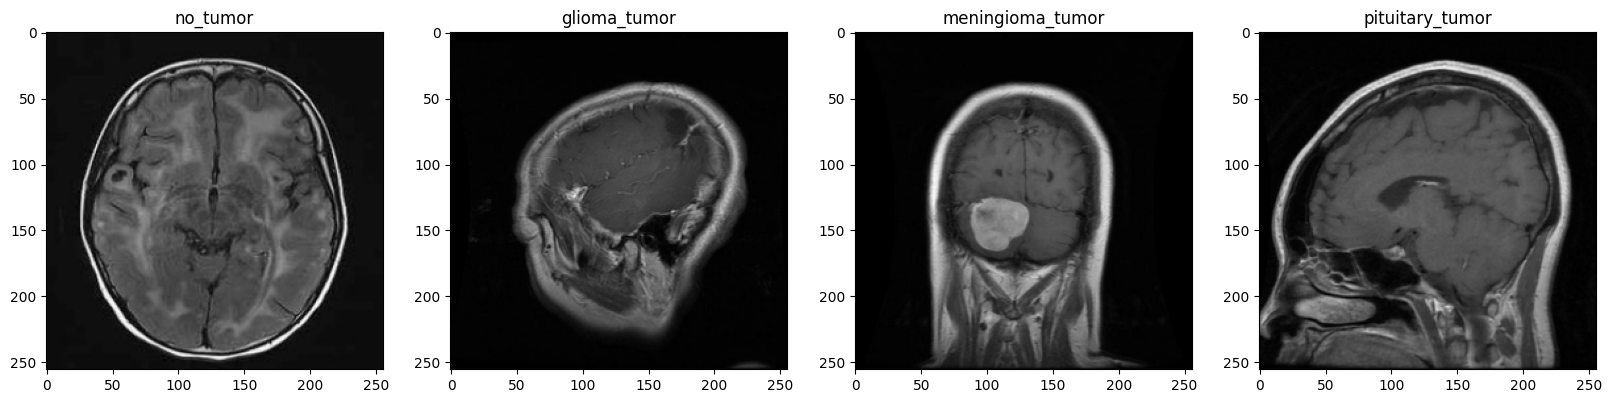

In [36]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    #ax[idx].title.set_text(batch_training[1][img_index])
    ax[idx].title.set_text(class_names[batch_training[1][img_index]])


#### Labels
-   0 : Glioma Tumor
-   1 : Meningioma Tumor
-   2 : No Tumor
-   3 : Pituitary Tumor


# Preprocessing Data

In [37]:
num_classes = 4  # Adjust based on your number of classes

# # Load the training dataset
Training_data = Training_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# # Load the validation dataset
Validation_data = Validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# # Load the testing dataset
Testing_data = Testing_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# X is Images
# Y is the images

In [38]:
Training_data.as_numpy_iterator().next()[1]
arr = Training_data.as_numpy_iterator().next()[1]

In [39]:
#pos = [np.where(row == 1)[0][0].tolist() for row in arr]

In [ ]:
#pos

In [41]:
# import tensorflow as tf

# # Assuming original labels are 0, 1, 2, 3 where 0 is "no tumor"
# original_labels = class_names

# # Map original classes to binary classes
# binary_labels = [0 if label == 'no_tumor' else 1 for label in original_labels]

# # Convert to TensorFlow tensors
# original_labels_tensor = tf.constant(original_labels)
# binary_labels_tensor = tf.constant(binary_labels)

# print("Original Labels:", original_labels_tensor.numpy())
# print("Binary Labels:", binary_labels_tensor.numpy())

In [42]:
labels_training = []
labels_validation = []
labels_testing = []
X_train =[]
X_val = []
X_test = []

# Assuming `your_dataset` is your batched dataset
for batch in Training_data.as_numpy_iterator():
    x_train, y_train = batch
    y_train = [np.where(row == 1)[0][0].tolist() for row in y_train] # GETS POSITION OF 1s to classify type of tumor
    # Process your data here

    # Convert y to binary labels (0 for "no tumor", 1 for "tumor")
    binary_labels = np.array([0 if label == 2 else 1 for label in y_train]) # if no tumor convert to 0, else convert integer to 1
    labels_training.extend(binary_labels.tolist())
    X_train.extend(x_train)
    # Your further processing...

for batch in Validation_data.as_numpy_iterator():
    x_validation, y_val = batch
    y_val = [np.where(row == 1)[0][0].tolist() for row in y_val]
    # Process your data here

    # Convert y to binary labels (0 for "no tumor", 1 for "tumor")
    binary_labels = np.array([0 if label == 2 else 1 for label in y_val])
    labels_validation.extend(binary_labels.tolist())
    X_val.extend(x_validation)
    # Your further processing...


for batch in Testing_data.as_numpy_iterator():
    x_test, y_test = batch
    y_test = [np.where(row == 1)[0][0].tolist() for row in y_test]
    # Process your data here

    # Convert y to binary labels (0 for "no tumor", 1 for "tumor")
    binary_labels = np.array([0 if label == 2 else 1 for label in y_test])
    labels_testing.extend(binary_labels.tolist())
    X_test.extend(x_test)
    # Your further processing...

labels_training = np.array(labels_training)
labels_validation = np.array(labels_validation)
labels_testing = np.array(labels_testing)
X_train = np.array(X_train)
X_val = np.array(X_val )
X_test = np.array(X_test)

In [43]:
print(labels_training[0:20])
# print(labels_validation[0:20])
print(labels_testing[0:20])


[0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1]
[1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0]


In [44]:
print(len(labels_training))
print(len(labels_validation))
print(len(labels_testing))

2328
582
394


These lengths match those from earlier when we loaded in the data so we now proceed

In [45]:
# Let us now convert this to a binary classifier


In [46]:
# num_classes = 4  # Adjust based on your number of classes

# # Load the training dataset
# Training_data = Training_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# # Load the validation dataset
# Validation_data = Validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# # Load the testing dataset
# Testing_data = Testing_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# # X is Images
# # Y is Labels


In [47]:
Training_data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [48]:
batch_training = Training_data.as_numpy_iterator().next()
batch_testing = Testing_data.as_numpy_iterator().next()


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


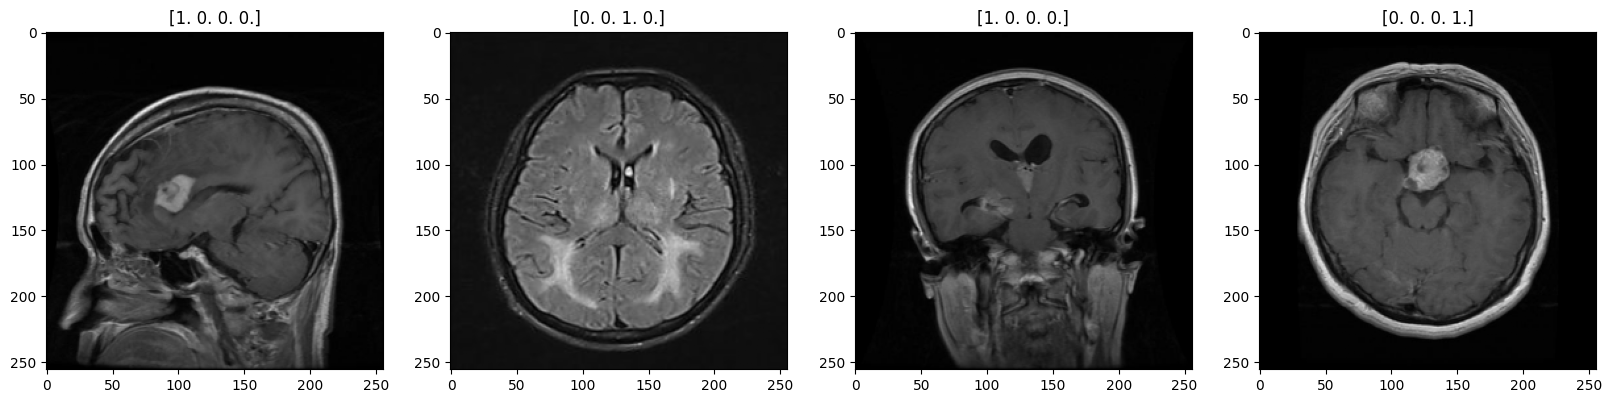

In [49]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index])
    ax[idx].title.set_text(batch_training[1][img_index])


#### Labels
-   [1,0,0,0] : Glioma Tumor
-   [0,1,0,0]  : Meningioma Tumor
-   [0,0,1,0]  : No Tumor
-   [0,0,0,1]  : Pituitary Tumor


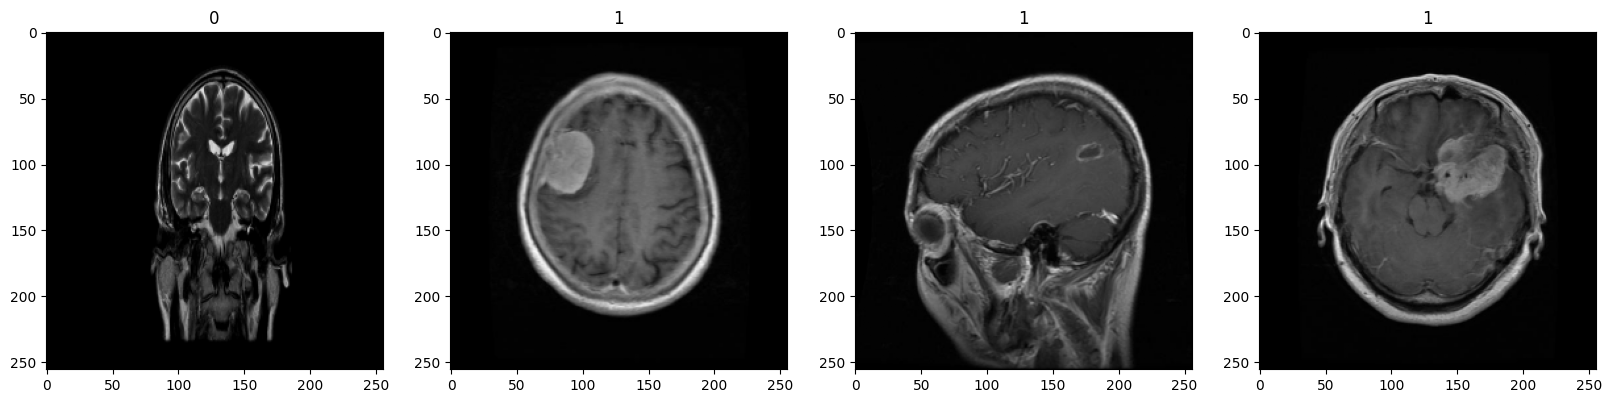

In [50]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([0,1,2,3]):
    ax[idx].imshow(X_train[img_index])
    ax[idx].title.set_text(labels_training[img_index])


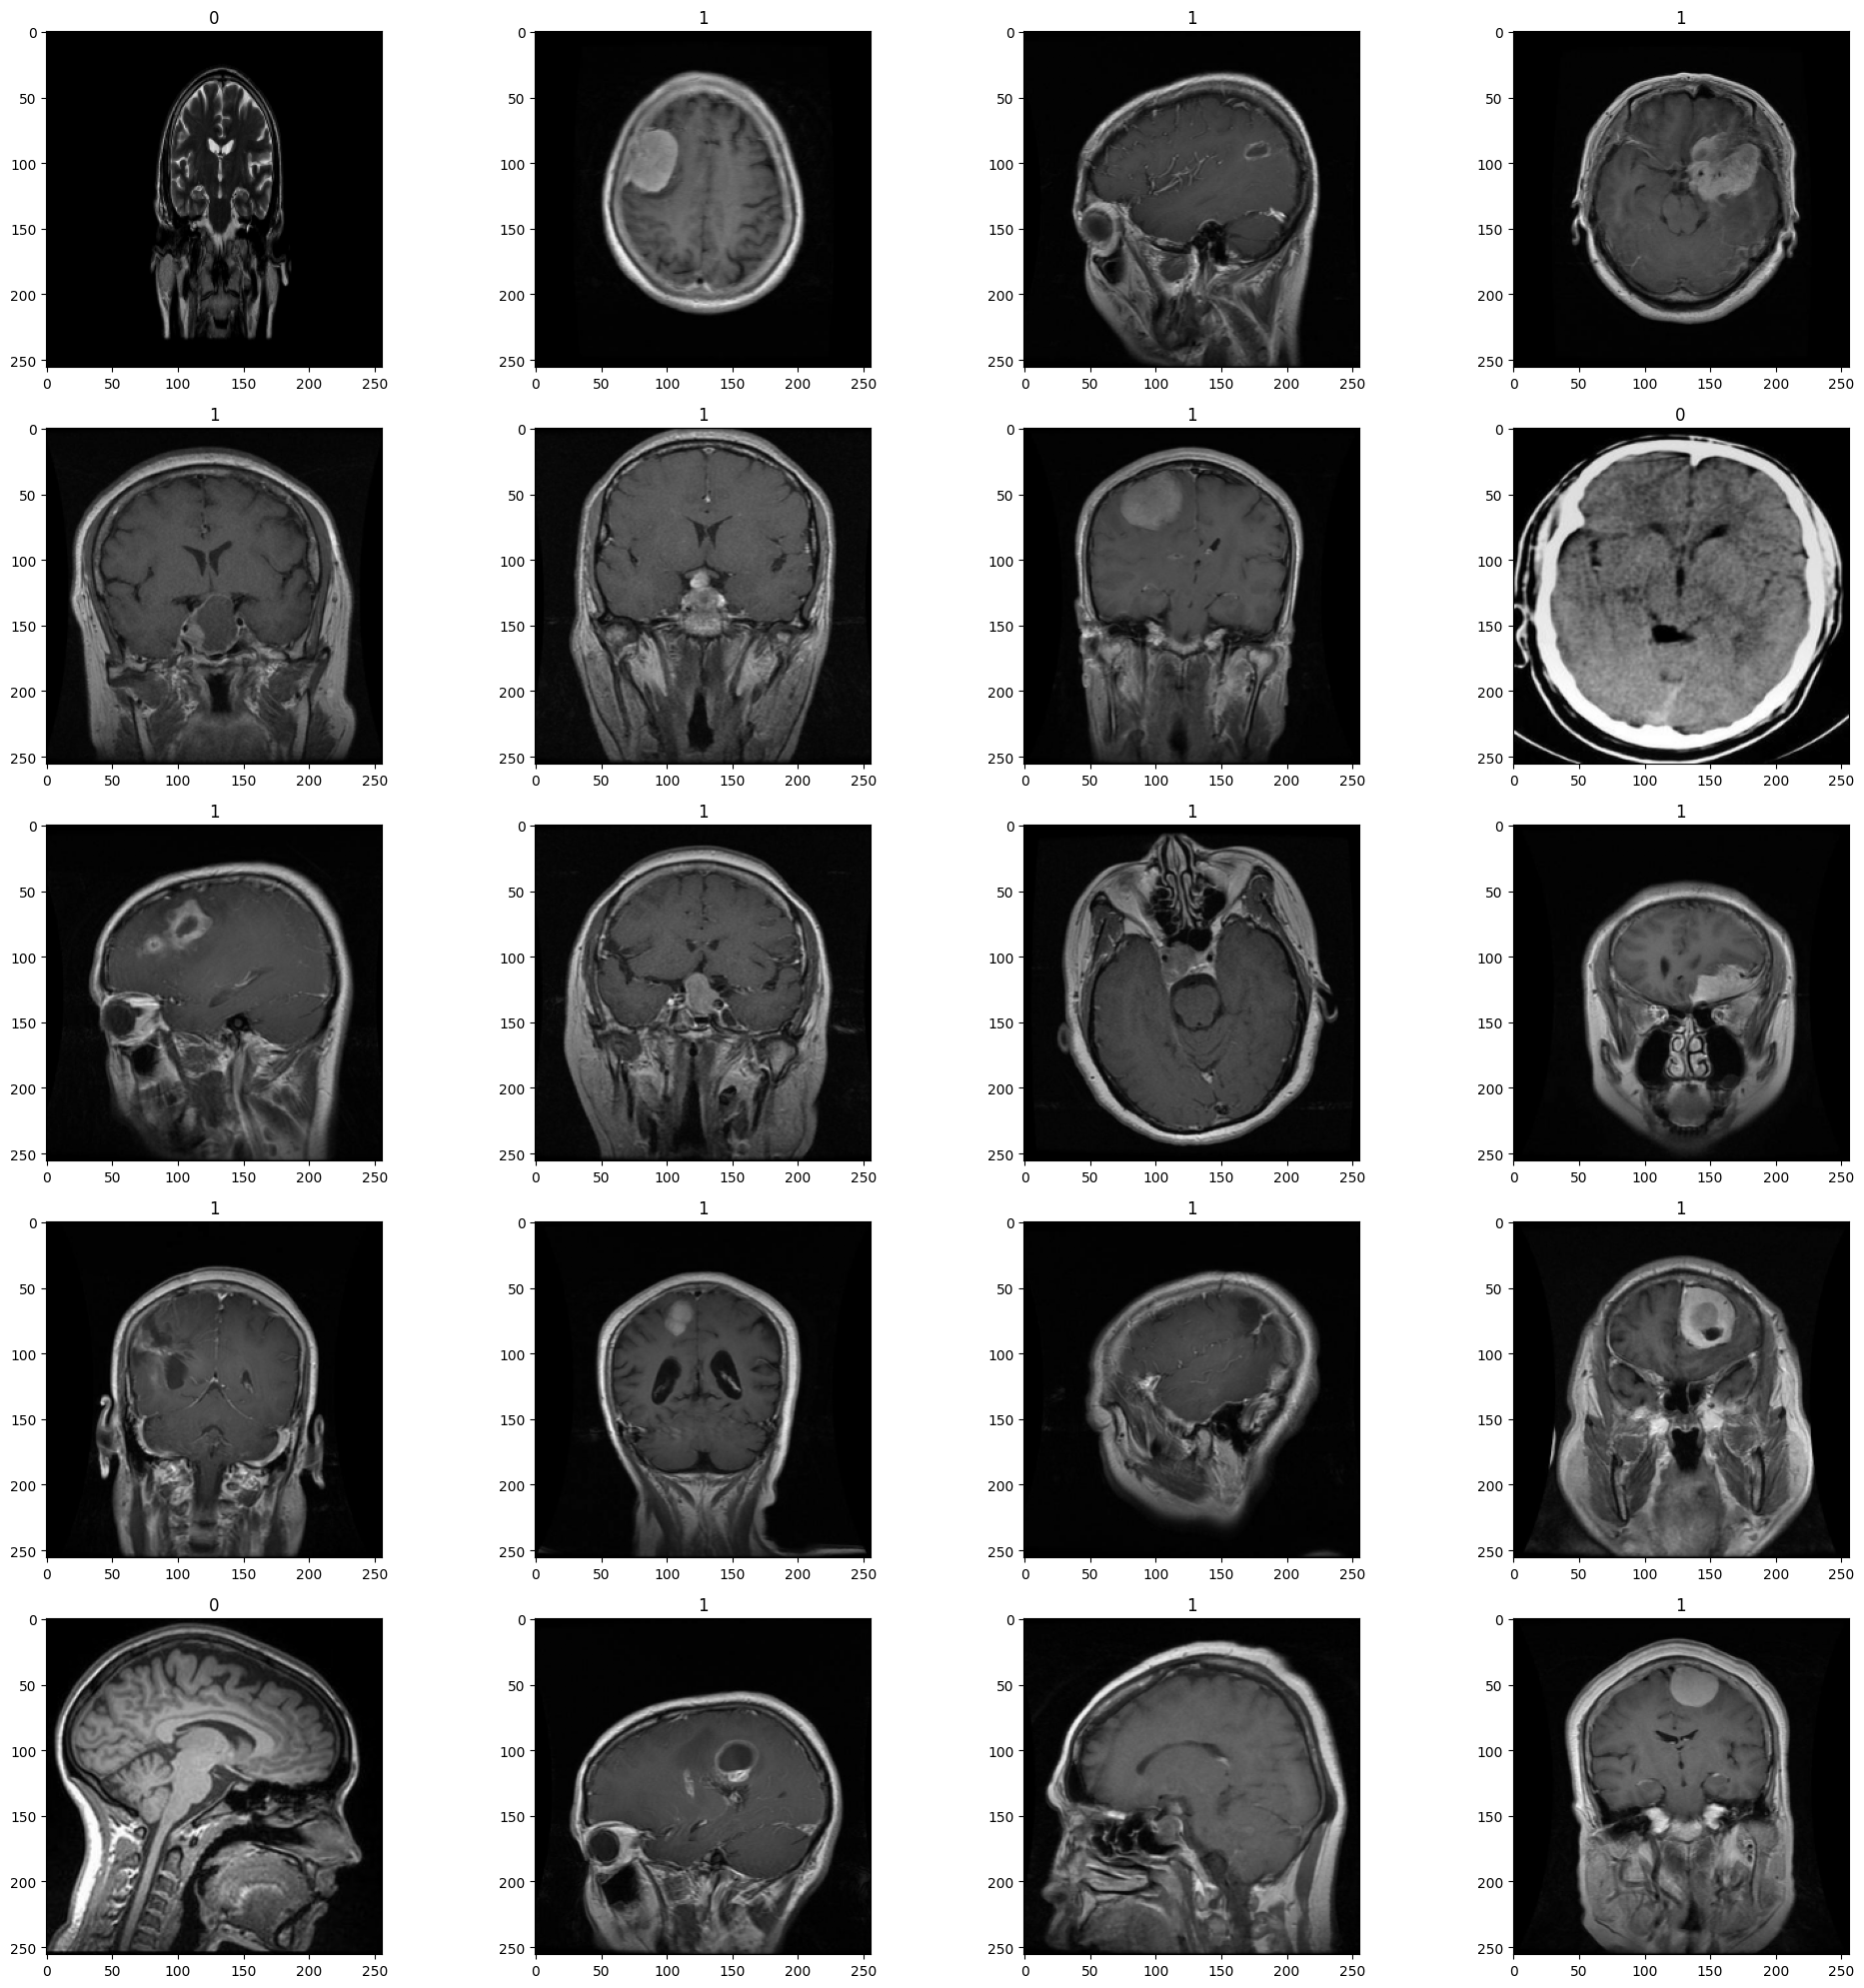

In [51]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))

# Reshape the axes to flatten the grid
ax = ax.flatten()

# Display the first 20 images
for idx, img_index in enumerate(range(20)):
    ax[idx].imshow(X_train[img_index])
    ax[idx].title.set_text(labels_training[img_index])

# Hide empty subplots
# for i in range(20, len(ax)):
    # ax[i].axis('off')

plt.tight_layout()
plt.show()


# Deep Model

In [52]:
# google how to use dropout

In [53]:
# keras.tuning
#optuner

In [54]:
model = Sequential()

# First have an input layer, going to have 16 filters, filter is a 3x3, stride of 1
# Relu activation turns negative values to 0, and preserves positive values
model.add(Conv2D(64, (3,3), 1, activation = 'relu', input_shape = IMAGE_SIZE))
model.add(MaxPooling2D())

model.add(Conv2D(125, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

#model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
#model.add(MaxPooling2D())

model.add(Flatten()) # condense values

# Fully connected layers
model.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.002)))
# model.add(Dropout(rate=0.1))

model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.002)))
#model.add(Dropout(rate=0.1))


# Final layer that gives a single output and represets the label
model.add(Dense(4, activation = 'softmax'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer= OPT, loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
# model = Sequential()
# model.add(Conv2D(32,(3,3),activation = 'relu',input_shape = IMAGE_SIZE))
# model.add(Conv2D(64,(3,3),activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(Dropout(0.3))
# model.add(Conv2D(64,(3,3),activation='relu'))
# model.add(Conv2D(64,(3,3),activation='relu'))
# model.add(Dropout(0.3))
# model.add(MaxPooling2D(2,2))
# model.add(Dropout(0.3))
# model.add(Conv2D(128,(3,3),activation='relu'))
# model.add(Conv2D(128,(3,3),activation='relu'))
# model.add(Conv2D(128,(3,3),activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(Dropout(0.3))
# model.add(Conv2D(128,(3,3),activation='relu'))
# model.add(Conv2D(256,(3,3),activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(Dropout(0.3))
# model.add(Flatten())
# model.add(Dense(512,activation = 'relu'))
# model.add(Dense(512,activation = 'relu'))
# model.add(Dropout(0.3))

# model.compile(optimizer= OPT, loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 125)     72125     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 125)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 480500)            0         
                                                                 
 dense (Dense)               (None, 64)                3

#### Training

In [57]:
logdir = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [ ]:
hist = model.fit(X_train, labels_training, epochs = 15, validation_data = (X_val, labels_validation), callbacks = [tensorboard_callback, early_stopping])

In [59]:
#tf.debugging.disable_traceback_filtering()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Hypertuning

#### We can see that there is some overfitting, so we shall implement hyperparameter tuning to get the optimum values.

In [62]:
# from keras import backend as K

# def model_builder(hp):

#   K.clear_session()
#   model = tf.keras.Sequential()

#   Conv_layer_1 = hp.Int('conv_layer_1', min_value=1, max_value=256, step=32)
#   Conv_layer_2 = hp.Int('conv_layer_2', min_value=1, max_value=256, step=32)
#   Dense_layer_1 = hp.Int('Dense_layer_1', min_value =1, max_value = 256, step = 32)
#   Dense_layer_2 = hp.Int('Dense_layer_2', min_value =1, max_value = 256, step = 32)
#   #L2_regularisation = hp.Choice('L2_penalty', values = [0.001, 0.003, 0.005,0.01,0.05])
#   #Dropout_rate = hp.Choice('Dropout', values = [0.05, 0.1, 0.2])
#   #learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
#   kernel_size = (3,3)
#   INPUT_SHAPE = (256,256,3)
#   learning_rate = 0.001



#   model.add(tf.keras.layers.Conv2D(filters = Conv_layer_1, kernel_size = kernel_size, activation = 'LeakyReLU', input_shape = INPUT_SHAPE))
#   model.add(tf.keras.layers.Conv2D(filters = Conv_layer_2, kernel_size = kernel_size, activation = 'LeakyReLU'))
#   model.add(tf.keras.layers.Flatten())

#   model.add(tf.keras.layers.Dense(units = Dense_layer_1, activation = 'LeakyReLU'))
#   model.add(tf.keras.layers.Dense(units = Dense_layer_2, activation = 'LeakyReLU'))
#   model.add(tf.keras.layers.Dense(units = 4, activation = 'Softmax'))

#   model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'],
#                 run_eagerly=True)


#   return model

In [63]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_accuracy',
#                      max_epochs=10,
#                      factor=3,
#                      directory='dir',
#                      project_name='x')

# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# tuner.search(Training_data, epochs=50, validation_data = Validation_data, callbacks=[stop_early])

The use of automated hypertuning librarys was trialed however due to the heavy ram usage I was unable to utilise them and thus have decided to stick to manual tuning of the model.

# Evaluating and Testing


In [64]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [65]:
# for batch in Testing_data.as_numpy_iterator():
#   X, y = batch
#   yhat = model.predict(X)
#   y = y.astype(int)
#   yhat_binary = (yhat > 0.5).astype(int)
#   pre.update_state(y, yhat_binary)
#   re.update_state(y, yhat_binary)
#   acc.update_state(y, yhat_binary)


In [66]:
y_ = labels_testing
yhat_ =[]
#for X, y in Testing_data.unbatch().as_numpy_iterator():
  #  yhat = model.predict(np.expand_dims(X, axis=0), verbose=0)
yhat = model.predict(X_test)
#y = np.array(labels_test, dtype=int)
y = labels_testing
yhat_binary = (yhat > 0.5).astype(int).flatten()

#y_.append(y)
yhat_.append(yhat_binary)
#print('y',y)
#print('yhay', yhat_binary)
pre.update_state(y_, yhat_binary)
re.update_state(y_, yhat_binary)
acc.update_state(y_, yhat_binary)


13/13 [==============================] - 7s 601ms/step


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=394.0>

In [67]:
labels_testing[0:5]

array([1, 0, 1, 1, 0])

In [68]:
yhat[0:5]

array([[0.71446687],
       [0.71446687],
       [0.71446687],
       [0.71446687],
       [0.71446687]], dtype=float32)

In [69]:
yhat_binary[0:5]

array([1, 1, 1, 1, 1])

In [ ]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')



Testing

In [71]:
# hist2 = model.predict(Testing_data)
# testing_pred = np.argmax(hist2, axis=1)
# testing_class = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
# testing_true = Testing_data.class_names

In [72]:
y_[:5][0]

1

In [73]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_, yhat_binary)

In [ ]:
class_names = ['No_Tumor', 'Tumor']
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
np.where(y_ == 1)[0][1][0]

In [ ]:
indexes_list_y = [np.where(row == 1)[0][0] for row in y]
indexes_list_yhat = [np.where(row == 1)[0][0] for row in yhat_binary]

In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(indexes_list_y, indexes_list_yhat)

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()